In [1]:
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

base_dir = Path("Dataset")
IMG_HEIGHT = 244
IMG_WIDTH = 244
BATCH_SIZE = 8

# Enhanced data augmentation
train_datagen = ImageDataGenerator(
   rescale=1.0/255,
   rotation_range=40,
   width_shift_range=0.3,
   height_shift_range=0.3,
   shear_range=0.3,
   zoom_range=0.3,
   horizontal_flip=True,
   vertical_flip=True,
   brightness_range=[0.7,1.3],
   channel_shift_range=50,
   fill_mode='nearest',
   validation_split=0.2
)



# Generate multiple augmented versions
def augment_directory(source_dir, num_augmented=5):
   for class_dir in source_dir.iterdir():
       if not (class_dir / 'augmented').exists():
            augment_directory(base_dir)
       if class_dir.is_dir():
           aug_dir = class_dir / 'augmented'
           aug_dir.mkdir(exist_ok=True)
           
           for img_path in class_dir.glob('*.[jp][pn][g]'):
               img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
               x = img_to_array(img)
               x = x.reshape((1,) + x.shape)
               
               i = 0
               for batch in train_datagen.flow(x, batch_size=1,
                                             save_to_dir=aug_dir,
                                             save_prefix=f'aug_{img_path.stem}',
                                             save_format='jpg'):
                   i += 1
                   if i >= num_augmented:
                       break

# Create generators
train_generator = train_datagen.flow_from_directory(
   base_dir,
   target_size=(IMG_HEIGHT, IMG_WIDTH),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
   subset='training'
)

validation_generator = train_datagen.flow_from_directory(
   base_dir,
   target_size=(IMG_HEIGHT, IMG_WIDTH),
   batch_size=BATCH_SIZE,
   class_mode='categorical', 
   subset='validation'
)

print("Classes:", train_generator.class_indices)
print("Training samples:", train_generator.samples)
print("Validation samples:", validation_generator.samples)

Found 438 images belonging to 5 classes.
Found 106 images belonging to 5 classes.
Classes: {'Allergies': 0, 'Autoimmune': 1, 'Healthy': 2, 'Infections': 3, 'Parasites': 4}
Training samples: 438
Validation samples: 106


Training Fold 1...
Epoch 1/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.5602 - loss: 1.1495 - val_accuracy: 0.8428 - val_loss: 0.4570
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.7383 - loss: 0.6809 - val_accuracy: 0.8698 - val_loss: 0.3824
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.7821 - loss: 0.5734 - val_accuracy: 0.8862 - val_loss: 0.3177
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.8350 - loss: 0.4419 - val_accuracy: 0.8952 - val_loss: 0.3316
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.8490 - loss: 0.3642 - val_accuracy: 0.8982 - val_loss: 0.2813
Fold 1 Accuracy: 0.8428143858909607
Training Fold 2...
Epoch 1/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.7113 - loss: 0.7214 - val_accuracy: 0.8533 - val_loss: 0.3687
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.7714 - loss: 0.5648 - val_accuracy: 0.8787 - val_loss: 0.2988
Epoch 3/20
3

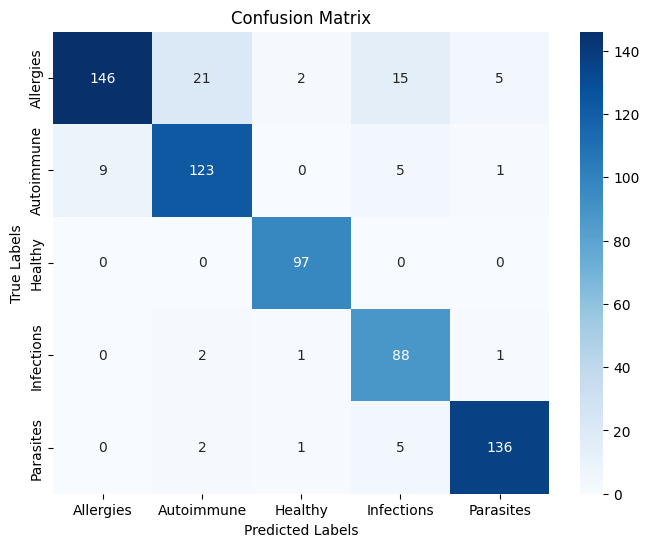

Classification Report:
              precision    recall  f1-score   support

   Allergies       0.94      0.77      0.85       189
  Autoimmune       0.83      0.89      0.86       138
     Healthy       0.96      1.00      0.98        97
  Infections       0.78      0.96      0.86        92
   Parasites       0.95      0.94      0.95       144

    accuracy                           0.89       660
   macro avg       0.89      0.91      0.90       660
weighted avg       0.90      0.89      0.89       660



In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Initialize KFold with augmented dataset
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_model = None
best_accuracy = 0
best_fold = None
accuracies = []
fold = 1

for train_index, test_index in kf.split(train_generator.filenames):
   # Get batches for this fold
   train_data = []
   train_labels = []
   test_data = []
   test_labels = []
   
   # Collect training data
   for i in train_index:
       batch = next(train_generator)
       train_data.extend(batch[0])
       train_labels.extend(batch[1])
   
   # Collect test data  
   for i in test_index:
       batch = next(validation_generator)
       test_data.extend(batch[0])
       test_labels.extend(batch[1])

   train_data = np.array(train_data)
   train_labels = np.array(train_labels)
   test_data = np.array(test_data) 
   test_labels = np.array(test_labels)

   print(f"Training Fold {fold}...")
   history = model.fit(
       train_data, train_labels,
       validation_data=(test_data, test_labels),
       epochs=20,
       batch_size=BATCH_SIZE,
       callbacks=[early_stopping],
       verbose=1
   )
   
   eval_result = model.evaluate(test_data, test_labels, verbose=0)
   accuracies.append(eval_result[1])
   print(f"Fold {fold} Accuracy: {eval_result[1]}")
   
   if eval_result[1] > best_accuracy:
       best_accuracy = eval_result[1]
       best_fold = fold
       best_model = model
   
   fold += 1

print(f"Cross-Validation Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")
print(f"Best Fold: {best_fold} with Accuracy: {best_accuracy}")

# Confusion Matrix
y_pred = best_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
           xticklabels=train_generator.class_indices.keys(),
           yticklabels=train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, 
     target_names=train_generator.class_indices.keys()))